# Enrichment analysis for m6A peak with 
Fisher Exact test for m6A peak and RBP binding sites / microRNA.

Data on [cloud drive](https://github.com/gaow/m6A/blob/master/writeup/Private_Links.md)

In [1]:
import pandas as pd, numpy as np
from pybedtools import BedTool
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from fisher import pvalue
import pickle
import os

In [2]:
path = os.path.expanduser("~/Documents/m6A/")
input_m6A_peak = f"{path}/Data/metApeakFisher/unmerged_peaks_metApeak.bed"
input_m6A_peak_merged = f"{path}/Data/metApeakFisher/joint_merged_peaks_counts.xlsx"
input_m6A_nonpeak = f"{path}/Data/metApeakFisher/unmerged_nonpeaks_metApeak.bed"
input_RBP = f"{path}/Data/all.RBP.intersect.hg19.bed"
input_intersect_peak = f"{path}/Data/metApeakFisher/peak.intersect.RBP.bed"
input_intersect_nonpeak = f"{path}/Data/metApeakFisher/nonpeak.intersect.RBP.bed"
input_intersect_peak_merged = f"{path}/Data/metApeakFisher/peak.merged.intersect.RBP.bed"
output_m6A_peak_merged = f"{path}/Data/metApeakFisher/joint_merged_peaks_counts.bed"
output_RBP_fisher = f"{path}/output/output_RBP_fisher.pkl"
# microRNA
input_miRNA = f"{path}/Data/miRNA_target_in_YRI_LCLs.bed"
output_miRNA = f"{path}/Data/miRNA.bed"
input_intersect_peak_miRNA = f"{path}/Data/metApeakFisher/peak.intersect.miRNA.bed"
input_intersect_peak_merged_miRNA = f"{path}/Data/metApeakFisher/peak.merged.intersect.miRNA.bed"
input_intersect_nonpeak_miRNA = f"{path}/Data/metApeakFisher/nonpeak.intersect.miRNA.bed"
output_miRNA_fisher = f"{path}/output/output_miRNA_fisher.pkl"

In [3]:
def save_data(data, filename):
    pickle.dump(data, open(filename, "wb"))

In [4]:
p = 0.05

## Step 1: Data preprocess
Prepare and export bed file; load m6A peak/nonpeak and RBP binding datasets; check data quality before using.

### Prepare m6A peak/nonpeak data.
#### Export merged m6A peaks bed file

- In order to use `bedtools` to obtain intersection of RBP and m6A peak, first we need to convert the original merged m6A peak, which is an excel, to bed file, then export.

- Only need to do it once. bed file must be tab separated, false index, column "chr" rename to "# chr".

In [5]:
m6A_peaks_merged = pd.read_excel(input_m6A_peak_merged, usecols = [0,1,2,3,4,5])
m6A_peaks_merged = m6A_peaks_merged.rename(columns = {"chr": "# chr"})
m6A_peaks_merged.to_csv(output_m6A_peak_merged, index = False, sep = "\t")

#### Load unmerged m6A peaks and unmerged nonpeaks

In [7]:
m6A_peaks = pd.read_table(input_m6A_peak, header = 0)
m6A_peaks = m6A_peaks.sort_values(by = ["# chr", "chromStart"])
m6A_peaks = m6A_peaks.rename(columns = {"# chr": "chr"})
# m6A_peaks = m6A_peaks[m6A_peaks["score"] < 0.05]

In [8]:
m6A_nonpeaks = pd.read_table(input_m6A_nonpeak, header = 0)
m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["# chr", "chromStart"])
m6A_nonpeaks = m6A_nonpeaks.rename(columns = {"# chr": "chr"})
# m6A_nonpeaks = m6A_nonpeaks.iloc[:10000, :]

In [9]:
print (m6A_peaks.shape, m6A_peaks_merged.shape, m6A_nonpeaks.shape)

(184390, 12) (27795, 6) (282904, 12)


### Prepare and filter RBP binding sites by widths
#### Load RBP binding sites and remove RBP binding sites less than 200 bps, then display all RBPs after it.

In [10]:
RBP_binding_sites = pd.read_table(input_RBP, sep="\t", header = None, 
                                  names = ["chr", "start", "end", "RBP", "peak_width", "strand"])
RBP_binding_sites = RBP_binding_sites[RBP_binding_sites["peak_width"] <= 200]
RBP_name = set(RBP_binding_sites["RBP"])
RBP_name = list(RBP_name)
RBP_name.sort()
print (set(RBP_binding_sites["RBP"]))

{'FKBP4', 'NSUN2', 'HNRNPC', 'TIAL1', 'TRA2A', 'IGF2BP1', 'SF3A3', 'UPF1', 'TROVE2', 'FASTKD2', 'KHDRBS1', 'EIF4G1', 'RBM5', 'TBRG4', 'FUS', 'NONO', 'SMNDC1', 'SAFB2', 'SUB1', 'PPIL4', 'LARP4', 'DHX30', 'NCBP2', 'SLTM', 'SUGP2', 'DDX55', 'HNRNPA1', 'SRSF7', 'PUS1', 'DDX24', 'LSM11', 'KHSRP', 'HLTF', 'GEMIN5', 'LIN28B', 'EFTUD2', 'IGF2BP2', 'ILF3', 'RBFOX2', 'PCBP2', 'ZRANB2', 'FXR2', 'ZNF622', 'GTF2F1', 'TNRC6A', 'EIF4G2', 'DDX42', 'FTO', 'HNRNPK', 'DGCR8', 'XPO5', 'GRSF1', 'SFPQ', 'SUPV3L1', 'YWHAG', 'EXOSC5', 'POLR2G', 'SF3B4', 'QKI', 'CPSF6', 'DDX6', 'SLBP', 'DDX59', 'FUBP1', 'U2AF2', 'AUH', 'SRSF9', 'GPKOW', 'GRWD1', 'XRCC6', 'RPS5', 'CSTF2', 'LARP7', 'FMR1', 'NOL12', 'DDX3X', 'TIA1', 'PRPF8', 'SERBP1', 'XRN2', 'BUD13', 'EWSR1', 'FUBP3', 'FAM120A', 'BCCIP', 'SBDS', 'TAF15', 'SF3B1', 'NOLC1', 'NKRF', 'HNRNPM', 'RBM27', 'IGF2BP3', 'SND1', 'HNRNPU', 'DROSHA', 'EIF3D', 'RPS3', 'PPIG', 'FXR1', 'PUM2', 'EIF3H', 'METAP2', 'DKC1', 'U2AF1', 'RBM22', 'UCHL5', 'NPM1', 'RPS11', 'CDC40', 'TARDB

#### Display histogram of RBP binding sites widths.
Binding widths concentrate around 30 bps.

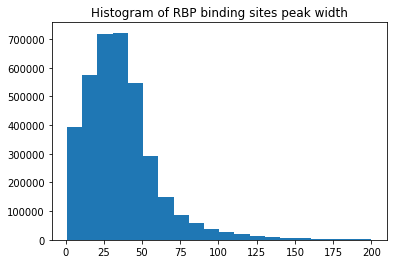

In [11]:
peak_width = RBP_binding_sites["peak_width"].tolist()
plt.hist(peak_width, bins = 20)  # arguments are passed to np.histogram
plt.title("Histogram of RBP binding sites peak width")
plt.show()

## Step 2: Obtain intersection of m6A peak and RBP
For merged/unmerged m6A peak and unmerged nonpeak, obtain their intersections with RBP binding sites respectively.

Use `bedtools` in bash under the depository `~/Documents/m6A/Data/metApeakFisher`.

### Unmerged m6A peak/nonpeak
First Sort each m6A peak/nonpeak bed file.
```
sort -k1,1 -k2,2n unmerged_peaks_metApeak.bed > peaks.bed
sort -k1,1 -k2,2n unmerged_nonpeaks_metApeak.bed > nonpeaks.bed
```
Then use `bedtools` to obtain intersection of m6A and RBP.
```
bedtools intersect -a ../all.RBP.intersect.hg19.bed -b peaks.bed -s > peak.intersect.RBP.bed
bedtools intersect -a ../all.RBP.intersect.hg19.bed -b nonpeaks.bed -s > nonpeak.intersect.RBP.bed
```
### Merged m6A peak
Since we do not have merged m6A nonpeak data, we use unmerged nonpeak instead (already sort and get intersection above).
```
sort -k1,1 -k2,2n joint_merged_peaks_counts.bed > peaks.merged.bed
bedtools intersect -a ../all.RBP.intersect.hg19.bed -b peaks.merged.bed -s > peak.merged.intersect.RBP.bed
```

## Step 3: Enrichment analysis for m6A and RBP
Perform Fisher's exact test for each RBP binding site.

For each RBP, we need to obtain the four following numbers before Fisher's test:

1. its number of intersections with m6A peaks
2. the total number of intersections for all RBPs with m6A peaks minus (1)
3. its number of intersections with m6A nonpeaks
4. the total number of intersections for all RBPs with m6A nonpeaks minus (3)

In [12]:
def read_intersect(fn, head = None, cols = ["chr", "chromStart", "chromEnd", "name", "inter_width", "strand"]):
    return pd.read_table(fn, header = head, names = cols)

In [13]:
def get_fisher(peak_fn, nonpeak_fn, peak_merge = False, cols = ['name', 'n_inter_peak', 'n_inter_nonpeak', 
                                                                'n_nointer_peak', 'n_nointer_nonpeak', 
                                                                'fisher_p', 'odds_ratio']):
    peaks_intersect = read_intersect(peak_fn)
    peaks_intersect["peak"] = 1
    nonpeaks_intersect = read_intersect(nonpeak_fn)
    nonpeaks_intersect["peak"] = 0
    intersect = peaks_intersect.append(nonpeaks_intersect)
    fisher_stats = pd.DataFrame(columns = cols)
    idx = 0
    sum_inter_peak = peaks_intersect.shape[0]
    sum_inter_nonpeak = nonpeaks_intersect.shape[0]
    for RBP in list(set(intersect["name"])):
        fisher_stats.loc[idx, 'name'] = RBP
        n_inter_peak = intersect[(intersect["name"] == RBP) & (intersect["peak"] == 1)].shape[0]
        n_inter_nonpeak = intersect[(intersect["name"] == RBP) & (intersect["peak"] == 0)].shape[0]
        n_nointer_peak = sum_inter_peak - n_inter_peak
        n_nointer_nonpeak = sum_inter_nonpeak - n_inter_nonpeak
        fisher_stats.loc[idx, 'n_inter_peak'] = n_inter_peak
        fisher_stats.loc[idx, 'n_inter_nonpeak'] = n_inter_nonpeak
        fisher_stats.loc[idx, 'n_nointer_peak'] = n_nointer_peak
        fisher_stats.loc[idx, 'n_nointer_nonpeak'] = n_nointer_nonpeak
        fisher_stats.loc[idx, 'fisher_p'] = stats.fisher_exact([[n_inter_peak, n_inter_nonpeak], 
                                                                [n_nointer_peak, n_nointer_nonpeak]])[1]
        fisher_stats.loc[idx, 'odds_ratio'] = stats.fisher_exact([[n_inter_peak, n_inter_nonpeak], 
                                                                  [n_nointer_peak, n_nointer_nonpeak]])[0]
        idx += 1
    fisher_stats = fisher_stats.sort_values(by = ["odds_ratio"], ascending = False)
    fisher_stats = fisher_stats.set_index([[i for i in range(fisher_stats.shape[0])]])
    return fisher_stats

In [ ]:
fn1 = input_intersect_peak_merged
fn2 = input_intersect_nonpeak
fn3 = input_intersect_peak
fisher_peak_merge = get_fisher(peak_fn = fn1, nonpeak_fn = fn2)
fisher_peak_unmerge = get_fisher(peak_fn = fn3, nonpeak_fn = fn2)

In [ ]:
save_data(fisher_peak_merge, output_RBP_fisher)

### potential m6A binding proteins
Check the test statistics for potential m6A binding proteins (RBPs contain keywords "YTHDF", "HNRNP", "FMRP", "IGF2BP" or "G3BP").

There are no RBPs that contains keywords "YTHDF" or "G3BP". Only "HNRNP", "FMR1" and "IGF2BP" are found, including 'IGF2BP3', 'HNRNPUL1', 'HNRNPA1', 'HNRNPM', 'IGF2BP1', 'FMR1', 'HNRNPK', 'HNRNPU', 'IGF2BP2', 'HNRNPC'.

In [ ]:
RBP_potential = ["YTHDF", "HNRNP", "FMR1", "IGF2BP", "G3BP"]
RBP_names = fisher_peak_merge["name"].tolist()
RBPs_potential = list()
for RBP in RBP_names:
    tmp = [RBP for item in RBP_potential if RBP.find(item) == 0]
    RBPs_potential.extend(tmp)
print (RBPs_potential)

### Fisher test statistics of RBP binding sites with merged m6A peaks and unmerged nonpeaks

In [15]:
fisher_peak_merge

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,RBM15,5300,1565,859486,740576,0,2.91805
1,NCBP2,3198,1000,861588,741141,1.07934e-197,2.75093
2,DDX3X,5296,1726,859490,740415,4.69948e-307,2.64327
3,IGF2BP3,3947,1522,860839,740619,6.24384e-171,2.23113
4,FASTKD2,1647,717,863139,741424,1.04665e-55,1.97315
5,TRA2A,2553,1128,862233,741013,1.6042e-82,1.9451
6,DDX6,1416,631,863370,741510,1.68964e-45,1.92732
7,SLTM,1849,844,862937,741297,1.74622e-55,1.88195
8,FUS,103,47,864683,742094,0.000285908,1.88079
9,XRN2,2668,1239,862118,740902,7.36408e-76,1.85058


In [17]:
res = pd.read_pickle(output_RBP_fisher)
output_RBP_fisher_excel = f"{path}/output/output_RBP_fisher.xlsx"
writer = pd.ExcelWriter(output_RBP_fisher_excel)
res.to_excel(writer)
writer.save()

### Test statistics of potential m6A binding proteins (merged m6A peaks and unmerged nonpeaks)

In [16]:
fisher_peak_merge[fisher_peak_merge["name"].isin(RBPs_potential)]

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
3,IGF2BP3,3947,1522,860839,740619,6.24384e-171,2.23113
39,HNRNPUL1,1359,834,863427,741307,1.26388e-14,1.39903
40,HNRNPA1,6224,3837,858562,738304,5.5737e-60,1.39489
43,HNRNPM,5988,3742,858798,738399,1.19999e-53,1.37587
46,IGF2BP1,4282,2848,860504,739293,2.11425e-26,1.29173
48,FMR1,12088,8075,852698,734066,9.05598e-70,1.2887
55,HNRNPK,3247,2228,861539,739913,2.79703e-16,1.25162
56,HNRNPU,5687,3948,859099,738193,5.79733e-25,1.23775
71,IGF2BP2,15260,11806,849526,730335,1.32338e-17,1.11121
99,HNRNPC,46750,44553,818036,697588,1.18857e-59,0.894811


### Test statistics of potential m6A binding proteins (unmerged m6A peaks and unmerged nonpeaks)

In [17]:
fisher_peak_unmerge[fisher_peak_unmerge["name"].isin(RBPs_potential)]

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
8,IGF2BP3,4586,1522,1148761,740619,2.16158e-122,1.94261
34,FMR1,18832,8075,1134515,734066,1.76903e-217,1.50896
41,IGF2BP1,6264,2848,1147083,739293,1.5377e-55,1.41753
46,IGF2BP2,24619,11806,1128728,730335,9.28274e-160,1.34927
51,HNRNPUL1,1626,834,1151721,741307,7.53018e-08,1.25489
59,HNRNPA1,7037,3837,1146310,738304,8.12827e-17,1.18121
65,HNRNPK,3923,2228,1149424,739913,2.16906e-06,1.13345
73,HNRNPM,6148,3742,1147199,738399,0.00724526,1.0575
78,HNRNPU,6215,3948,1147132,738193,0.527598,1.01303
115,HNRNPC,47454,44553,1105893,697588,0,0.671865


## Step 4: Enrichment analysis for m6A and miRNA
Perform Fisher's exact test for each microRNA.

In [18]:
miRNA = pd.read_table(input_miRNA, header = 0, usecols = [0,1,2,3,5,10,11,12])
miRNA["name_gene"] = miRNA.apply(lambda row: row["name"].split(":")[0], axis = 1)

There are 55 microRNAs included in dataset.

Binding sites in one block are not always single. For example, "6,1" and "2,5" also exists in "blockSize".

In [19]:
print (Counter(miRNA["miRNA"]), "\n", len(set(miRNA["miRNA"])))
print (Counter(miRNA["blockSize"]))

Counter({'hsa-miR-330-3p': 2310, 'hsa-miR-17-5p': 1693, 'hsa-miR-340-5p': 1670, 'hsa-miR-182-5p': 1618, 'hsa-miR-183-5p': 1482, 'hsa-miR-140-3p': 1319, 'hsa-miR-25-3p': 1209, 'hsa-miR-186-5p': 1146, 'hsa-miR-142-3p': 1105, 'hsa-miR-141-3p': 1066, 'hsa-miR-142-5p': 1065, 'hsa-miR-505-3p': 743, 'hsa-miR-582-5p': 737, 'hsa-miR-22-3p': 709, 'hsa-miR-155-5p': 624, 'hsa-miR-143-3p': 563, 'hsa-miR-221-3p': 563, 'hsa-miR-132-3p': 553, 'hsa-miR-212-5p': 506, 'hsa-miR-140-5p': 466, 'hsa-miR-223-3p': 449, 'hsa-miR-185-5p': 445, 'hsa-miR-21-5p': 435, 'hsa-miR-150-5p': 402, 'hsa-miR-532-3p': 390, 'hsa-miR-542-3p': 390, 'hsa-miR-874-3p': 366, 'hsa-miR-342-3p': 354, 'hsa-miR-361-5p': 325, 'hsa-miR-335-5p': 322, 'hsa-miR-425-5p': 311, 'hsa-miR-331-3p': 283, 'hsa-miR-532-5p': 270, 'hsa-miR-28-5p': 269, 'hsa-miR-423-5p': 269, 'hsa-miR-192-5p': 240, 'hsa-miR-296-5p': 230, 'hsa-miR-328-3p': 228, 'hsa-miR-339-5p': 225, 'hsa-miR-501-3p': 225, 'hsa-miR-491-5p': 209, 'hsa-miR-362-5p': 202, 'hsa-miR-486-5p': 1

microRNA blockCount can be 1 or 2. If blockCount is 2, blockSize and blockStarts contain two numbers, binding sites in one block are not continuous.

For rows whose blockCount is 2, split the row into two rows according to blockSize and blockStarts.

1. For rows with 2-blockstart sites, split blockSize and blockStarts into two rows.
2. "start": original start + interval betweem two blockstart sites
3. "end": start from last step + blockSize

In [20]:
# separate the blocks with multiple blockSize
cols_miRNA = ["chr", "start", "end", "miRNA", "blockSize", "strand"]
single_block_miRNA = miRNA[miRNA["blockSize"].isin(["7", "8"])][cols_miRNA]
multi_block_miRNA = miRNA[~miRNA["blockSize"].isin(["7", "8"])]

In [21]:
tmp_col = ['chr', 'start', 'end', 'name', 'strand', 'miRNA', 'name_gene']
tmp_miRNA = pd.DataFrame(columns = tmp_col + ["blockSize", "interval"])
i = 0
for index, row in multi_block_miRNA.iterrows():
    if len(row["blockSize"].split(",")) != len(row["blockStarts"].split(",")):
        print ("The length of 'blockSize' and 'blockStarts' are different")
        break
    else:
        for num in range(len(row["blockSize"].split(","))):
            tmp1 = [int(row["blockSize"].split(",")[num]), int(row["blockStarts"].split(",")[num])]
            tmp = row[tmp_col].tolist()
            tmp.extend(tmp1)
            tmp_miRNA.loc[i] = tmp
            i += 1

In [22]:
tmp_miRNA["start"] = tmp_miRNA.apply(lambda row: row["start"] + row["interval"], axis = 1)
tmp_miRNA["end"] = tmp_miRNA.apply(lambda row: row["start"] + row["blockSize"], axis = 1)

An example of splitting a row with two blockSize/blockStarts into two rows.

In [23]:
tmp_miRNA[tmp_miRNA["name_gene"] == "NRD1"]

,chr,start,end,name,strand,miRNA,name_gene,blockSize,interval
4,chr1,52260280,52260282,NRD1:miR-505-3p.1,-,hsa-miR-505-3p,NRD1,2,0
5,chr1,52260494,52260500,NRD1:miR-505-3p.1,-,hsa-miR-505-3p,NRD1,6,214


In [24]:
single_block_miRNA = single_block_miRNA.append(tmp_miRNA[cols_miRNA])

Export bed file of unique block start and end in each row

In [25]:
cols_sortby = ["miRNA", "chr", "start"]
single_block_miRNA.sort_values(by = cols_sortby).to_csv(output_miRNA, index = False, header = False, sep = "\t")

## Obtain intersection of m6A peak and miRNA
Use `bedtools` to obtain intersect of peak/nonpeak with miRNA under the folder
`~/Documents/m6A/Data/metApeakFisher`
```
bedtools intersect -a ../miRNA.bed -b peaks.bed -s > peak.intersect.miRNA.bed
bedtools intersect -a ../miRNA.bed -b peaks.merged.bed -s > peak.merged.intersect.miRNA.bed
bedtools intersect -a ../miRNA.bed -b nonpeaks.bed -s > nonpeak.intersect.miRNA.bed
```

Load data of intersections of m6A peak and miRNA.

In [26]:
fn4 = input_intersect_peak_miRNA
fn5 = input_intersect_nonpeak_miRNA
fn6 = input_intersect_peak_merged_miRNA
fisher_peak_merge_miRNA = get_fisher(peak_fn = fn4, nonpeak_fn = fn5)
fisher_peak_unmerge_miRNA = get_fisher(peak_fn = fn6, nonpeak_fn = fn5)

In [27]:
save_data(fisher_peak_merge_miRNA.sort_values(by =["odds_ratio"], ascending = False), output_miRNA_fisher)
fisher_peak_merge_miRNA.sort_values(by =["odds_ratio"], ascending = False)

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,hsa-miR-615-3p,6,1,4103,5579,0.0468574,8.15842
1,hsa-miR-423-3p,14,3,4095,5577,0.000993382,6.35556
2,hsa-miR-210-3p,12,3,4097,5577,0.00652049,5.44496
3,hsa-miR-127-3p,8,2,4101,5578,0.0223117,5.44062
4,hsa-miR-1249-3p,7,2,4102,5578,0.0422105,4.75939
5,hsa-miR-423-5p,58,37,4051,5543,0.000337447,2.14491
6,hsa-miR-212-5p,116,78,3993,5502,1.02772e-06,2.0492
7,hsa-miR-296-5p,63,43,4046,5537,0.000488117,2.00503
8,hsa-miR-328-3p,53,38,4056,5542,0.00268099,1.90573
9,hsa-miR-331-3p,52,40,4057,5540,0.0077257,1.7752


### Fisher test statistics of microRNA binding sites with merged m6A peaks and unmerged nonpeaks
Select those miRNA with p-value less than 0.05.

In [28]:
fisher_peak_merge_miRNA[fisher_peak_merge_miRNA["fisher_p"] < p].sort_values(by = ["odds_ratio"], ascending = False)

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,hsa-miR-615-3p,6,1,4103,5579,0.0468574,8.15842
1,hsa-miR-423-3p,14,3,4095,5577,0.000993382,6.35556
2,hsa-miR-210-3p,12,3,4097,5577,0.00652049,5.44496
3,hsa-miR-127-3p,8,2,4101,5578,0.0223117,5.44062
4,hsa-miR-1249-3p,7,2,4102,5578,0.0422105,4.75939
5,hsa-miR-423-5p,58,37,4051,5543,0.000337447,2.14491
6,hsa-miR-212-5p,116,78,3993,5502,1.02772e-06,2.0492
7,hsa-miR-296-5p,63,43,4046,5537,0.000488117,2.00503
8,hsa-miR-328-3p,53,38,4056,5542,0.00268099,1.90573
9,hsa-miR-331-3p,52,40,4057,5540,0.0077257,1.7752


### Fisher test statistics of microRNA binding sites with unmerged m6A peaks and unmerged nonpeaks
All miRNA and those whose p-value less than 0.05.

In [29]:
fisher_peak_unmerge_miRNA.sort_values(by =["odds_ratio"], ascending = False)

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,hsa-miR-615-3p,6,1,3740,5579,0.0192407,8.95027
1,hsa-miR-423-3p,12,3,3734,5577,0.00244481,5.97429
2,hsa-miR-127-3p,8,2,3738,5578,0.0184756,5.96897
3,hsa-miR-210-3p,9,3,3737,5577,0.0177819,4.47712
4,hsa-miR-1249-3p,6,2,3740,5578,0.0671696,4.47433
5,hsa-miR-212-5p,105,78,3641,5502,2.73695e-06,2.0342
6,hsa-miR-423-5p,50,37,3696,5543,0.00131234,2.02666
7,hsa-miR-296-5p,56,43,3690,5537,0.00127683,1.95419
8,hsa-miR-328-3p,47,38,3699,5542,0.00524438,1.85309
9,hsa-miR-331-3p,48,40,3698,5540,0.00628328,1.79773


In [30]:
fisher_peak_unmerge_miRNA[fisher_peak_unmerge_miRNA["fisher_p"] < p].sort_values(by = ["odds_ratio"], ascending = False)

,name,n_inter_peak,n_inter_nonpeak,n_nointer_peak,n_nointer_nonpeak,fisher_p,odds_ratio
0,hsa-miR-615-3p,6,1,3740,5579,0.0192407,8.95027
1,hsa-miR-423-3p,12,3,3734,5577,0.00244481,5.97429
2,hsa-miR-127-3p,8,2,3738,5578,0.0184756,5.96897
3,hsa-miR-210-3p,9,3,3737,5577,0.0177819,4.47712
5,hsa-miR-212-5p,105,78,3641,5502,2.73695e-06,2.0342
6,hsa-miR-423-5p,50,37,3696,5543,0.00131234,2.02666
7,hsa-miR-296-5p,56,43,3690,5537,0.00127683,1.95419
8,hsa-miR-328-3p,47,38,3699,5542,0.00524438,1.85309
9,hsa-miR-331-3p,48,40,3698,5540,0.00628328,1.79773
10,hsa-miR-491-5p,38,32,3708,5548,0.0195254,1.77677
